<a href="https://colab.research.google.com/github/tneog/DeepLearning-Dark-Matter/blob/main/DeepLearning_DarkMatter_TNeog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jedi>=0.16

Generating 5000 diverse maps...
Starting training...
Epoch 1/100, Train Loss: 0.0038, Test Loss: 0.0037
Epoch 2/100, Train Loss: 0.0036, Test Loss: 0.0036
Epoch 3/100, Train Loss: 0.0036, Test Loss: 0.0036
Epoch 4/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 5/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 6/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 7/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 8/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 9/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 10/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 11/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 12/100, Train Loss: 0.0035, Test Loss: 0.0036
Epoch 13/100, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 14/100, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 15/100, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 16/100, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 17/100, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 18/100, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 19/100, Train 

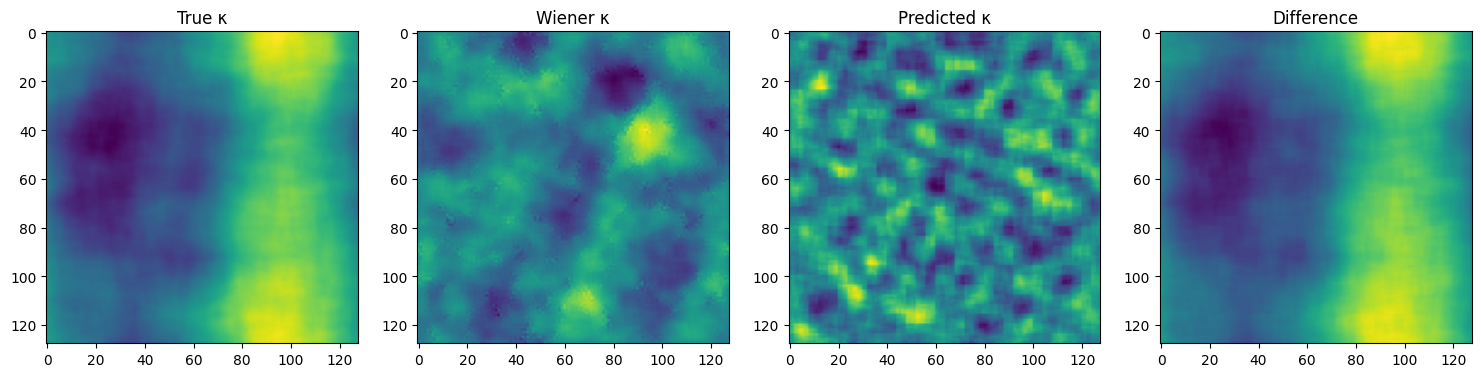

MSE (Predicted): 0.0078
MSE (Wiener): 0.0127


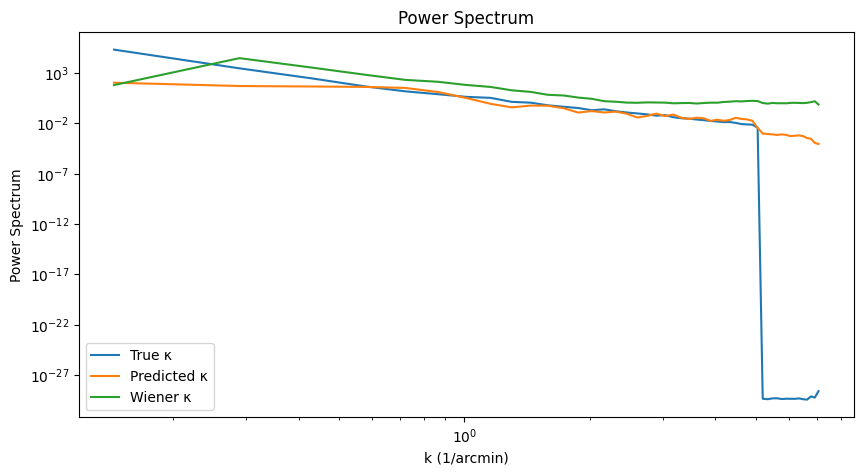

In [ ]:
# Install packages
!pip install galsim torch torchvision

# Imports
import galsim
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.signal import wiener
from scipy.fft import fft2, fftfreq

# Kaiser-Squires with normalization
def kaiser_squires(gamma1, gamma2, size):
    kx, ky = fftfreq(size), fftfreq(size)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2 + 1e-10
    gamma1_fft = fft2(gamma1)
    gamma2_fft = fft2(gamma2)
    kappa_fft = (kx**2 - ky**2) / k2 * gamma1_fft + (2 * kx * ky) / k2 * gamma2_fft
    return np.real(fft2(kappa_fft))

# Data generation with diverse power spectrum
size = 128
pixel_scale = 0.1
n_maps = 5000
rng = galsim.BaseDeviate(42)
shear_data = []
kappa_data = []

print("Generating 5000 diverse maps...")
for i in range(n_maps):
    exponent = np.random.choice([-2, -3, -4])
    amp = np.random.uniform(0.005, 0.015)
    noise_level = np.random.uniform(0.005, 0.015)
    ps = galsim.PowerSpectrum(e_power_function=lambda k: amp * k**exponent, b_power_function=lambda k: 0.0)
    grid = ps.buildGrid(grid_spacing=pixel_scale, ngrid=size, rng=rng)
    kappa = grid[0]
    shear_complex = grid[1]
    gamma1 = shear_complex.real
    gamma2 = shear_complex.imag
    gamma1_noisy = gamma1 + np.random.normal(0, noise_level, (size, size))
    gamma2_noisy = gamma2 + np.random.normal(0, noise_level, (size, size))
    shear = np.stack([gamma1_noisy, gamma2_noisy], axis=0)
    shear_data.append(shear)
    kappa_data.append(kappa)

shear_data = np.array(shear_data)
kappa_data = np.array(kappa_data)

# Split train/test
n_train = int(0.8 * n_maps)
train_shear = shear_data[:n_train]
train_kappa = kappa_data[:n_train]
test_shear = shear_data[n_train:]
test_kappa = kappa_data[n_train:]

train_shear_tensor = torch.tensor(train_shear, dtype=torch.float32)
train_kappa_tensor = torch.tensor(train_kappa, dtype=torch.float32).unsqueeze(1)
test_shear_tensor = torch.tensor(test_shear, dtype=torch.float32)
test_kappa_tensor = torch.tensor(test_kappa, dtype=torch.float32).unsqueeze(1)

# U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = nn.Conv2d(2, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        self.dec1 = nn.Conv2d(384, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(192, 64, 3, padding=1)
        self.dec3 = nn.Conv2d(64, 1, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.pool(e1)
        e3 = self.relu(self.enc2(e2))
        e4 = self.pool(e3)
        e5 = self.relu(self.enc3(e4))
        d1 = self.up(e5)
        d1 = torch.cat([d1, e3], dim=1)
        d2 = self.relu(self.dec1(d1))
        d2 = self.dropout(d2)
        d3 = self.up(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d4 = self.relu(self.dec2(d3))
        out = self.dec3(d4)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
train_shear_tensor = train_shear_tensor.to(device)
train_kappa_tensor = train_kappa_tensor.to(device)
test_shear_tensor = test_shear_tensor.to(device)
test_kappa_tensor = test_kappa_tensor.to(device)

# Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 100
batch_size = 32

print("Starting training...")
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for i in range(0, n_train, batch_size):
        batch_shear = train_shear_tensor[i:i+batch_size]
        batch_kappa = train_kappa_tensor[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(batch_shear)
        loss = criterion(outputs, batch_kappa)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_shear.size(0)
    train_loss /= n_train

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i in range(0, len(test_shear_tensor), batch_size):
            batch_test_shear = test_shear_tensor[i:i+batch_size]
            batch_test_kappa = test_kappa_tensor[i:i+batch_size]
            test_outputs = model(batch_test_shear)
            test_loss += criterion(test_outputs, batch_test_kappa).item() * batch_test_shear.size(0)
        test_loss /= len(test_shear_tensor)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    torch.cuda.empty_cache()

# Evaluation
model.eval()
with torch.no_grad():
    predicted_kappa = model(test_shear_tensor[0:1]).cpu().numpy()[0, 0]

# Wiener baseline
noisy_kappa = kaiser_squires(test_shear[0, 0], test_shear[0, 1], size)
noisy_kappa = (noisy_kappa - noisy_kappa.mean()) / noisy_kappa.std() * test_kappa[0].std() + test_kappa[0].mean()
wiener_pred = wiener(noisy_kappa, mysize=5)

# Graphs
print("Generating graphs...")
plt.figure(figsize=(15, 5))
plt.subplot(141); plt.imshow(test_kappa[0], cmap='viridis'); plt.title('True κ')
plt.subplot(142); plt.imshow(wiener_pred, cmap='viridis'); plt.title('Wiener κ')
plt.subplot(143); plt.imshow(predicted_kappa, cmap='viridis'); plt.title('Predicted κ')
plt.subplot(144); plt.imshow(test_kappa[0] - predicted_kappa, cmap='viridis'); plt.title('Difference')
plt.tight_layout()
plt.show()

mse_pred = np.mean((test_kappa[0] - predicted_kappa)**2)
mse_wiener = np.mean((test_kappa[0] - wiener_pred)**2)
print(f"MSE (Predicted): {mse_pred:.4f}")
print(f"MSE (Wiener): {mse_wiener:.4f}")

def compute_power_spectrum(map_data, pixel_size):
    fft_map = fft2(map_data)
    power = np.abs(fft_map)**2
    k = fftfreq(size) / pixel_size
    kx, ky = np.meshgrid(k, k)
    k_tot = np.sqrt(kx**2 + ky**2)
    bins = np.linspace(0, k_tot.max(), 50)
    bin_indices = np.digitize(k_tot, bins)
    power_binned = [power[bin_indices == i].mean() for i in range(1, len(bins)) if power[bin_indices == i].size > 0]
    return bins[1:len(power_binned)+1], power_binned

k_true, ps_true = compute_power_spectrum(test_kappa[0], pixel_scale)
k_pred, ps_pred = compute_power_spectrum(predicted_kappa, pixel_scale)
k_wiener, ps_wiener = compute_power_spectrum(wiener_pred, pixel_scale)

plt.figure(figsize=(10, 5))
plt.loglog(k_true, ps_true, label='True κ')
plt.loglog(k_pred, ps_pred, label='Predicted κ')
plt.loglog(k_wiener, ps_wiener, label='Wiener κ')
plt.xlabel('k (1/arcmin)')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum')
plt.legend()
plt.show()